# Import Libraries

In [42]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from choices import param_dict 
from utilities import deets

# Load data

In [99]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop).reset_index(drop=True)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class'].reset_index(drop=True)
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 41
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 41
_____________________________________________________


## Loss Function

In [100]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
le = LabelEncoder()
X = x.copy()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.20, random_state=42)

classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append('Class '+ str(v))
print(classes)

['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']


In [106]:
X_train

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
2944,5.111358,5.646006,5.778558,0.002203,8.803163,5.0,9.994832,5.0,1.525042e-09,0.005129,...,7.050218,5.423886,5.840490,NaN,5.636726,NaN,5.169142,3.943826,NaN,NaN
1536,7.610491,4.560796,NaN,NaN,2.244051,NaN,0.192767,0.0,2.257697e-07,0.043825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.107268
6477,8.152491,9.506211,NaN,NaN,3.142680,NaN,4.104670,0.0,NaN,0.009127,...,8.487985,3.193052,NaN,4.292405,NaN,4.999561,NaN,NaN,NaN,5.614035
4417,5.068515,8.045211,NaN,NaN,0.402026,NaN,5.679817,0.0,1.047742e-07,0.014854,...,3.597537,1.948951,3.002207,NaN,2.131429,NaN,2.597350,3.084125,NaN,NaN
501,4.625622,9.301923,NaN,NaN,3.751942,NaN,5.054523,0.0,1.433348e-08,0.008365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,7.852203,4.116931,NaN,NaN,0.672696,NaN,4.303495,0.0,1.444196e-07,0.016216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974436
5390,7.618770,6.515936,NaN,NaN,8.570394,NaN,9.895526,2.0,3.252157e-08,0.123521,...,7.132455,3.325635,6.322012,6.587556,4.241992,5.523624,4.996302,4.173444,5.260782,6.331830
860,6.705912,8.679780,NaN,NaN,1.308382,NaN,8.804317,0.0,2.595351e-07,0.439898,...,3.038294,3.105502,4.015918,NaN,3.425665,NaN,3.609031,3.749060,NaN,NaN
7603,9.700996,3.964450,NaN,NaN,5.749011,NaN,9.265183,1.0,4.703542e-10,0.001186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.141803,NaN,NaN


In [107]:
X_test

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
6598,7.354040,6.605140,9.999041,0.003615,8.828057,10.00,9.868903,5.0,3.084993e-08,0.009806,...,8.188117,3.295192,NaN,5.408613,NaN,5.091133,NaN,NaN,NaN,6.135338
4764,5.043282,0.471371,NaN,NaN,6.528629,NaN,5.983391,1.0,NaN,0.001113,...,7.089043,4.278240,5.566763,NaN,5.278652,NaN,5.886227,4.706485,NaN,NaN
7537,4.550458,2.103703,9.369711,0.001460,0.860270,7.50,3.788770,0.0,3.222953e-08,0.001210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.219436,3.885311,5.178947
2570,7.384548,6.577977,7.201973,0.004440,5.749197,6.25,8.154487,1.0,2.883134e-08,0.008949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2225,5.107444,5.649319,8.043627,0.001982,5.368315,6.25,9.804046,1.0,NaN,0.012978,...,5.921010,3.655387,4.821792,4.797378,4.216587,4.642633,4.607544,4.025832,4.956221,5.947368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,5.078605,7.364108,NaN,NaN,6.841016,NaN,7.978122,2.0,4.914478e-08,0.007594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.120208,NaN,NaN
188,7.366968,7.971812,9.999999,0.002471,5.288473,10.00,5.606995,1.0,9.328849e-11,0.000107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3032,7.834950,4.216996,9.927422,0.000956,4.685356,8.75,3.897336,0.0,1.358626e-08,0.006556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1201,4.164654,8.249741,NaN,NaN,4.997464,NaN,7.707717,0.0,NaN,0.010711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.693091,NaN,NaN


In [75]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score , recall_score , confusion_matrix , plot_confusion_matrix
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
#plot_confusion_matrix(cnf_matrix, labels=classes,normalize=True,  title='Confusion matrix')


Prediction accuracy 0.9279688513951979  recall  0.7581120165170178


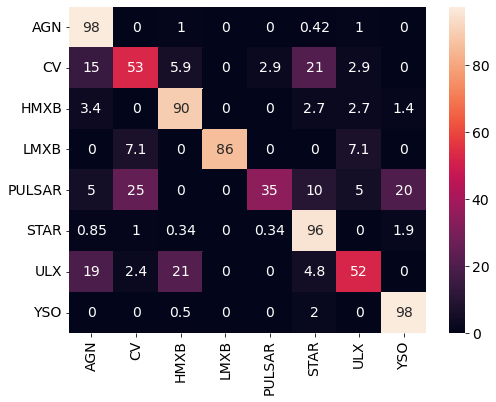

In [76]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(8,6))
l_name = le.inverse_transform(labeles)
sns.heatmap(cnf_matrix*100 , annot=True , xticklabels=l_name , yticklabels=l_name , ax=ax)
plt.show()

In [109]:
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss #get the FocalLoss implementation from Halford's blog

# Instantiate Focal loss
loss = FocalLoss(alpha=0.75, gamma=1.0)

# Not using early stopping
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
#clf.fit(X_train, y_train)

# Using early stopping
fit_params = {
    'eval_set': [(X_test, y_test)] , 
    'verbose':2 ,
    }
clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)


/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] \ is set=, \= will be ignored. Current value: \=
[LightGBM] [Warning] 6598 is set=, 6598= will be ignored. Current value: 6598=
[LightGBM] [Warning] 4764 is set=, 4764= will be ignored. Current value: 4764=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: ...,
[LightGBM] [Warning] Unknown parameter: 0.000107
[LightGBM] [Warning] Unknown parameter: 9.328849e-11
[LightGBM] [Warning] Unknown parameter: 0.007594
[LightGBM] [Warning] Unknown parameter: 4.914478e-08
[LightGBM] [Warning] Unknown parameter: 4.797378
[LightGBM] [Warning] Unknown parameter: 4.821792
[LightGBM] [Warning] Unknown parameter: 3.655387
[LightGBM] [Warning] Unknown parameter: 0.012978
[LightGBM] [Warning] Unknown parameter: columns],
[LightGBM] [Warning] Unknown parameter: 0.008949
[LightGBM] [Warning] Unknown parameter: 5.278652
[LightGBM] [Warning] Unknown parameter: 2.883134e-08
[LightGBM] [Warning] Unknown parameter: 3.222953e-08
[LightGBM] [Warning] Unknown parameter: 5.566763
[LightGBM] [Warning] Unknown parameter: Bp-W3
[LightGBM] [Warning] Unknown parameter: 4.278240
[LightGBM] [Warning] Unknown parameter: 7.834950
[LightGBM] [Warning] Unknown parameter: 5.921010
[LightGBM] [Warning] Unknown parameter: 9.999999
[LightGBM]

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
Training until validation scores don't improve for 10 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[10]	fit's focal_loss: 0.0397541	val's focal_loss: 0.0428751
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] 3077 is set=, 3077= will be ignored. Current value: 3077=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 188 is set=, 188= will be ignored. Current value: 188=
[LightGBM] [Warning] 10.00 is set=, 10.00= will be ignored. Current value: 10.00=
[LightGBM] [Warning] 1.0 is set=, 1.0= will be ignored. Current value: 1.0=
[LightGBM] [Warning] 3032 is set=, 3032= will be ignored. Current value: 3032=
[LightGBM] [Warning] 0.0 is set=, 0.0= will be ignored. Current value: 0.0=
[LightGBM] [Warning] 1201 is set=, 1201= will be ignored. Current value: 1201=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 0.0 is set=, 0.0= will be ignored. Current value: 0.0=
[LightGBM] [Warning] 2850 is set=, 2850= will be ignored. Current value: 2850=
[LightGBM] [Warning] 8.75 is set=, 8.75= will be ignored. Current value: 8.75=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current val

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: 3.222953e-08
[LightGBM] [Warning] Unknown parameter: 5.566763
[LightGBM] [Warning] Unknown parameter: Bp-W3
[LightGBM] [Warning] Unknown parameter: 4.278240
[LightGBM] [Warning] Unknown parameter: 7.834950
[LightGBM] [Warning] Unknown parameter: 5.921010
[LightGBM] [Warning] Unknown parameter: 9.999999
[LightGBM] [Warning] Unknown parameter: 5.091133
[LightGBM] [Warning] Unknown parameter: 1201
[LightGBM] [Warning] Unknown parameter: x
[LightGBM] [Warning] Unknown parameter: 5.749197
[LightGBM] [Warning] Unknown parameter: 5.078605
[LightGBM] [Warning] Unknown parameter: ...
[LightGBM] [Warning] Unknown parameter: 4.706485
[LightGBM] [Warning] Unknown parameter: 8.043627
[LightGBM] [Warning] Unknown parameter: 9.997766
[LightGBM] [Warning] Unknown parameter: 5.649319
[LightGBM] [Warning] Unknown parameter: 5.107444
[LightGBM] [Warning] Unknown parameter: 5.0
[LightGBM] [Warning] Unknown parameter: 0.009806
[LightGBM] [Warning] Unknown parameter: 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: 7.971812
[LightGBM] [Warning] Unknown parameter: var_intra_index_b
[LightGBM] [Warning] Unknown parameter: var_inter_prob_b
[LightGBM] [Warning] Unknown parameter: 9.999041
[LightGBM] [Warning] Unknown parameter: 6598
[LightGBM] [Warning] Unknown parameter: 4.550458
[LightGBM] [Warning] Unknown parameter: 6.605140
[LightGBM] [Warning] Unknown parameter: 0.001982
[LightGBM] [Warning] Unknown parameter: 0.003615
[LightGBM] [Warning] Unknown parameter: gal_l2
[LightGBM] [Warning] Unknown parameter: 2.103703
[LightGBM] [Warning] Unknown parameter: 8.249741
[LightGBM] [Warning] Unknown parameter: 5.043282
[LightGBM] [Warning] Unknown parameter: rows
[LightGBM] [Warning] Unknown parameter: 188
[LightGBM] [Warning] Unknown parameter: 7537
[LightGBM] [Warning] Unknown parameter: 3.897336
[LightGBM] [Warning] Unknown parameter: \
[LightGBM] [Warning] Unknown parameter: 4764
[LightGBM] [Warning] Unknown parameter: 8.188117
[LightGBM] [Warning] Unknown para

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2225 is set=, 2225= will be ignored. Current value: 2225=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] \ is set=, \= will be ignored. Current value: \=
[LightGBM] [Warning] 6598 is set=, 6598= will be ignored. Current value: 6598=
[LightGBM] [Warning] 4764 is set=, 4764= will be ignored. Current value: 4764=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [

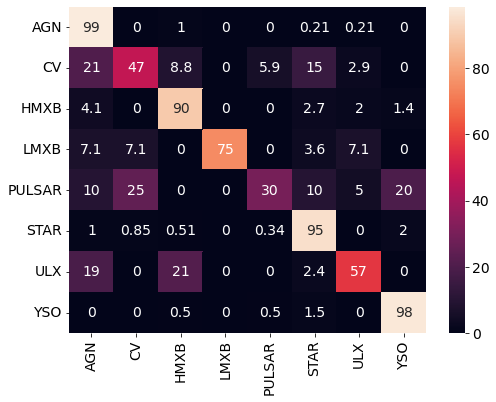

In [104]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(8,6))
l_name = le.inverse_transform(labeles)
sns.heatmap(cnf_matrix*100 , annot=True , xticklabels=l_name , yticklabels=l_name , ax=ax)
plt.show()